## Quantum energy teleportation protocol with minimal model

### Import packages

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit import transpile

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as sampler
from qiskit.visualization import plot_histogram

### Function to generate a circuit that measures the local term $Z$ or $H$

In [2]:
def qc_H(h,k):

    # Generate circuit
    qc = QuantumCircuit(2)

    #Prepare the ground state
    theta = -np.arcsin((1/np.sqrt(2))*(np.sqrt(1+h/np.sqrt(h**2+k**2))))

    qc.ry(2*theta,0)
    qc.cx(0,1)

    # Projective measurement on A
    qc.barrier()
    qc.h(0)

    # Condicional operation on B
    qc.barrier()
    phi = 0.5*np.arcsin((h*k)/np.sqrt((h**2+2*k**2)**2+(h*k)**2))

    qc.cry(-2*phi,0,1)
    
    qc.x(0)
    qc.cry(2*phi,0,1)
    qc.x(0)

    # measurement of Bob's Z term
    qc.measure_all()

    return qc

### Function to generate a circuit that measures the interaction term $XX$ or $V$

In [3]:
def qc_V(h,k):

    # Create circuit
    qc = QuantumCircuit(2)
    
    #Prepare the ground state
    theta = -np.arcsin((1/np.sqrt(2))*(np.sqrt(1+h/np.sqrt(h**2+k**2))))

    qc.ry(2*theta,0)
    qc.cx(0,1)

    # Projective measurement of A
    qc.barrier()
    qc.h(0)

    # Condicional operation on B
    qc.barrier()
    phi = 0.5*np.arcsin((h*k)/np.sqrt((h**2+2*k**2)**2+(h*k)**2))

    qc.cry(-2*phi,0,1)

    qc.x(0)
    qc.cry(2*phi,0,1)
    qc.x(0)

    # Measurement of the interaction term V
    qc.h(1)
    qc.measure_all()

    return qc

### Function to generate a circuit for estimator

In [4]:
def qc_T(h,k):

    # Create circuit
    qc = QuantumCircuit(2)
    
    #Prepare the ground state
    theta = -np.arcsin((1/np.sqrt(2))*(np.sqrt(1+h/np.sqrt(h**2+k**2))))

    qc.ry(2*theta,0)
    qc.cx(0,1)

    # Projective measurement of A
    qc.barrier()
    qc.h(0)

    # Condicional operation on B
    qc.barrier()
    phi = 0.5*np.arcsin((h*k)/np.sqrt((h**2+2*k**2)**2+(h*k)**2))

    qc.cry(-2*phi,0,1)

    qc.x(0)
    qc.cry(2*phi,0,1)
    qc.x(0)

    # Measurements
    qc.h(0)
    qc.measure_all()

    return qc

### Show quantum circuit

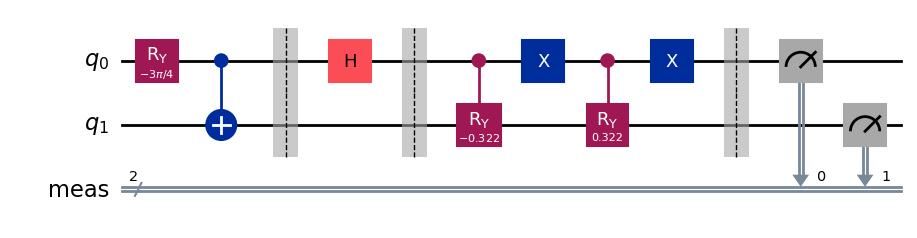

In [5]:
qc = qc_H(1, 1)
qc.draw('mpl')

### Simulate circuit H with aer simulator

In [29]:
# Initiate simulator
simulator = AerSimulator()

# Parameters
h = 1.5; k = 1;
n_shots = 100000

# Generate circuit
qc = qc_H(h, k)
qc_A = transpile(qc, simulator, optimization_level=3)

# Run job with Sampler
jobA_sim = sampler().run([qc_A], shots=n_shots)

### Simulate circuit $V$ with aer simulator

In [30]:
# Initiate simulator
simulator = AerSimulator()

# Parameters
h = 1.5; k = 1;
n_shots = 100000

# Generate circuit
qc = qc_V(h, k)
qc_B = transpile(qc, simulator, optimization_level=3)

# Run job with Sampler
jobB_sim = sampler().run([qc_B], shots=n_shots)

### Show results for simulated circuit $H$

Theoric energy injected by Alice 1.2480754415067656
H_A = 1.2435154415067657 ± 0.004743394571823009
H_B = 0.34582544150676564 ± 0.003789386411412803


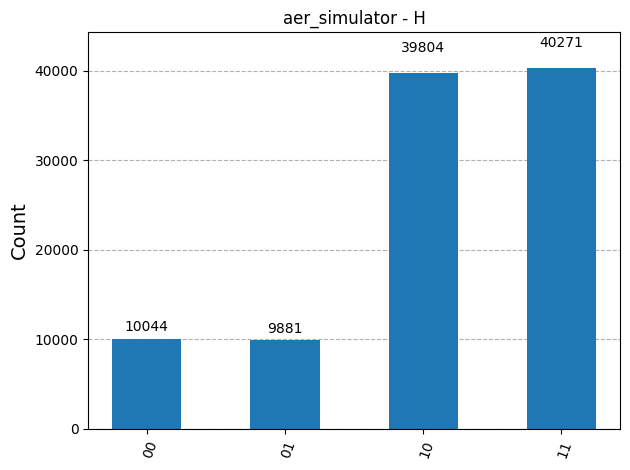

In [31]:
# Extract results
result = jobA_sim.result()[0]
counts = result.data.meas.get_counts()

# Energies
ene_A = (h**2)/(np.sqrt(h**2+k**2))
ene_B = (h**2)/(np.sqrt(h**2+k**2))

# Error arrays
error_A = []
error_B = []

# Calculate energies and errors
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_A += h*(-1)**int(bit_string[0])*count/n_shots
        ene_B += h*(-1)**int(bit_string[1])*count/n_shots

        for i in range(count):
            error_A.append(h*(-1)**int(bit_string[0]))
            error_B.append(h*(-1)**int(bit_string[1]))

# Print results
print("Theoric energy injected by Alice",h**2/np.sqrt(h**2+k**2))
print("H_A =",ene_A,"±",np.std(error_A)/np.sqrt(n_shots))
print("H_B =",ene_B,"±",np.std(error_B)/np.sqrt(n_shots))

plot_histogram(counts, title="aer_simulator - H")

### Show results for simulated circuit V

V = -0.4858796075495417 ± 0.0063245544652568205


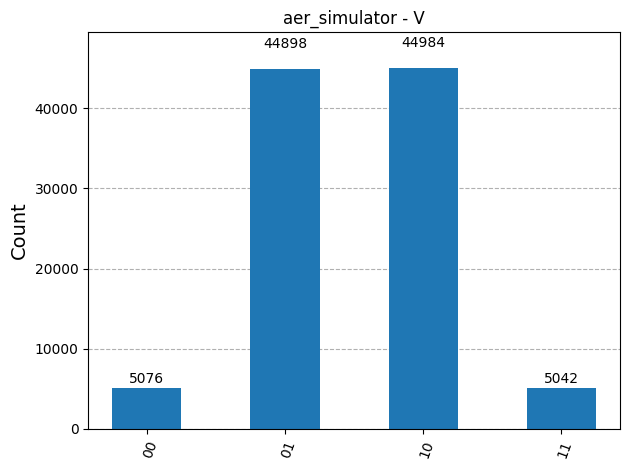

In [32]:
# Extract results
result = jobB_sim.result()[0]
counts = result.data.meas.get_counts()

# Energies
ene_V = (2*k**2)/(np.sqrt(h**2+k**2))

# Error arrays
error_V = []

# Calculate energies
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_V += 2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[1])*count/n_shots

        for i in range(count):
            error_V.append(2*k*(-1)**(int(bit_string[1])))

# Print results
print("V =",ene_V,"±",np.std(error_V)/np.sqrt(n_shots))

plot_histogram(counts, title='aer_simulator - V')

### Get backend and its properties

In [10]:
# Log in IBM platoform
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()

# Select least busy backend
backend = service.least_busy(operational=True)

# Get backend properties
props = backend.properties()

# Function to select specific properties
def describe_qubit(qubit, properties):
    """Print a string describing some of reported properties of the given qubit."""

    # Conversion factors from standard SI units
    us = 1e6
    ns = 1e9
    GHz = 1e-9

    print("Backend = {6}\n"
          "Qubit {0} has a \n"
          "  - T1 time of {1} microseconds\n"
          "  - T2 time of {2} microseconds\n"
          "  - U2 gate error of {3}\n"
          "  - U2 gate duration of {4} nanoseconds\n"
          "  - resonant frequency of {5} GHz".format(
              qubit,
              properties.t1(qubit) * us,
              properties.t2(qubit) * us,
              properties.gate_error('sx', qubit),
              properties.gate_length('sx', qubit) * ns,
              properties.frequency(qubit) * GHz,
              backend.name))

describe_qubit(0, props)

Backend = ibm_brisbane
Qubit 0 has a 
  - T1 time of 83.51966433411945 microseconds
  - T2 time of 42.35910768485592 microseconds
  - U2 gate error of 0.00092640312216779
  - U2 gate duration of 59.99999999999999 nanoseconds
  - resonant frequency of 4.721907253805372 GHz


### Run job with Sampler

In [ ]:
# Import Sampler 
from qiskit_ibm_runtime import Batch, SamplerV2 as sampler

# Parameters h and k
variables = [(1,0.2),(1,0.5),(1,1),(1.5,1),(1,1.5)]

#  Run job in Batch mode
with Batch(backend=backend):
    n_shots = 5000

    for variable in variables:
        h = variable[0]
        k = variable[1]

        # Generate circuits V and H
        circuit_H = qc_H(h,k)
        qc_A = transpile(circuit_H, backend=backend, optimization_level=3)

        circuit_V = qc_H(h,k)
        qc_B = transpile(circuit_V, backend=backend, optimization_level=3)
        
        # Run jobs for each circuit
        job_A = sampler().run([(qc_A)], shots=n_shots)
        print("Circuit H","ID =",job_A.job_id(), "h =",h, "k =",k)

        job_B = sampler().run([(qc_B)], shots=n_shots)
        print("Circuit V","ID =",job_B.job_id(), "h =",h, "k =",k) 

### Run job with Estimator

In [ ]:
# Import Estimator 
from qiskit_ibm_runtime import Batch, EstimatorV2 as estimator
from qiskit.transpiler import preset_passmanagers
from qiskit.quantum_info import SparsePauliOp 

# Parameters h and k
variables = [(1,0.2),(1,0.5),(1,1),(1.5,1),(1,1.5)]
#variables = [(1,1)]
transpiler = preset_passmanagers.generate_preset_pass_manager(optimization_level=3, backend=backend)

#  Run job in Batch mode
with Batch(backend=backend):

    for variable in variables:
        h = variable[0]
        k = variable[1]
        observables = [SparsePauliOp('ZI', h), SparsePauliOp('XX', 2*k)]

        # Generate circuit
        circuit_T = qc_T(h,k)
        qc_t = transpiler.run(circuit_T)
        
        # Run jobs
        transpiled_observable = observables[0].apply_layout(qc_t.layout)
        job_C = estimator(options={"resilience_level": 2}).run([(qc_t, transpiled_observable)]) 
        print("Estimator H","ID =",job_C.job_id(), "h =",h, "k =",k) 

        transpiled_observable = observables[1].apply_layout(qc_t.layout)
        job_D = estimator(options={"resilience_level": 2}).run([(qc_t, transpiled_observable)]) 
        print("Estimator V","ID =",job_D.job_id(), "h =",h, "k =",k) 

Estimator H ID = d0dcfged8drg008zdtyg h = 1 k = 1


qiskit_runtime_service.check_pending_jobs:WARNING:2025-05-06 22:39:02,447: The pending jobs limit has been reached. Waiting for job <RuntimeJobV2('d0dcf24qnmvg0087szh0', 'sampler')> to finish before submitting the next one.


Estimator V ID = d0dcgqakzhn0008w20y0 h = 1 k = 1


### Show results for circuit H

H_B = 0.28510678118654736 ± 0.012821201191776066
Estimated B = 0.24772683219229563 ± 0.018261788652163696


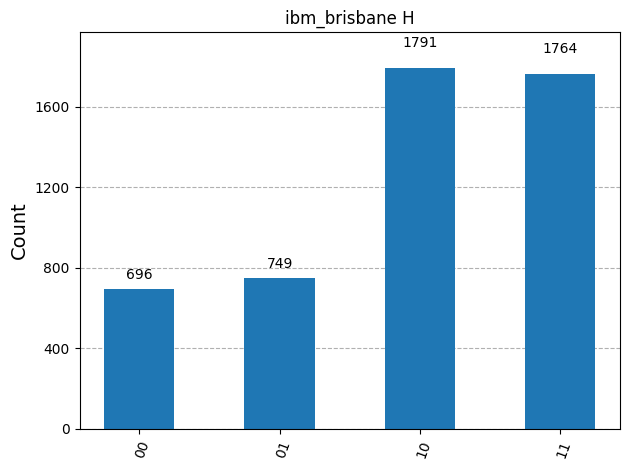

In [ ]:
# Extract results

# Sampler
jobS = service.job('czzxtx3nhqag008v1a5g')
result = jobS.result()[0]
counts = result.data.meas.get_counts()

# Estimator
jobT = service.job('d0byhfnrxz8g008akf00')
result = jobT.result()[0]
exp_value = result.data.evs
value_error = result.data.stds

# parameters
h = 1; k = 1;
n_shots = 5000

# Energies
ene_A = (h**2)/(np.sqrt(h**2+k**2))
ene_B = (h**2)/(np.sqrt(h**2+k**2))
est_B = exp_value + ene_B

# Error arrays
error_A = []
error_B = []

# Calculate errors
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_A += h*(-1)**int(bit_string[0])*count/n_shots
        ene_B += h*(-1)**int(bit_string[1])*count/n_shots

        for i in range(count):
            error_A.append(h*(-1)**int(bit_string[0]))
            error_B.append(h*(-1)**int(bit_string[1]))

# Print results
#print("Theoric energy injected by Alice",h**2/np.sqrt(h**2+k**2))
#print("H_A =",ene_A,"±",np.std(error_A)/np.sqrt(n_shots))
print("H_B =",ene_B,"±",np.std(error_B)/np.sqrt(n_shots))
print("Estimated B =",est_B,"±",value_error)

plot_histogram(counts, title=f"{backend.name} H")

### Show results for circuit V

V = -0.32498643762690504 ± 0.028265112913271724
Estimated V = -0.3923585615645657 ± 0.020807835017131654


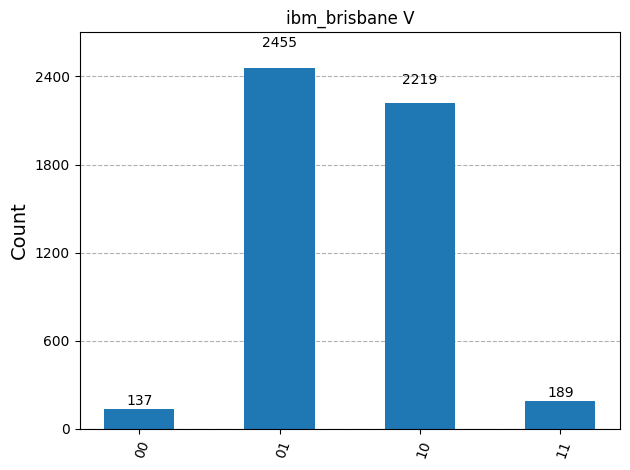

In [ ]:
# Extract results

# Sampler
jobS = service.job('czzxtvknhqag008v1a40')
result = jobS.result()[0]
counts = result.data.meas.get_counts()

# Estimator
jobT = service.job('d0byhhy6rr3g0087np90')
result = jobT.result()[0]
exp_value = result.data.evs
value_error = result.data.stds

# Parameters 
h = 1;k = 1;
n_shots = 5000

# Energies
ene_V = (2*k**2)/(np.sqrt(h**2+k**2))
est_V = exp_value + ene_V

# Erros arrays
error_V = []

# Calculate energies and errors
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_V += 2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[1])*count/n_shots

        for i in range(count):
            error_V.append(2*k*(-1)**(int(bit_string[1])))

# Print results
print("V =",ene_V,"±",np.std(error_V)/np.sqrt(n_shots))
print("Estimated V =",est_V,"±",value_error)

plot_histogram(counts, title=f"{backend.name} V")

## Extra: Initial ground state energy

H_A = 0.0020467811865474417 ± 0.002242521786739206
H_B = 0.0020467811865474417 ± 0.002242521786739206
V = 0.005373562373094859 ± 0.006324458264231016
E_A = 0.007420343559642301
E_B = 0.007420343559642301


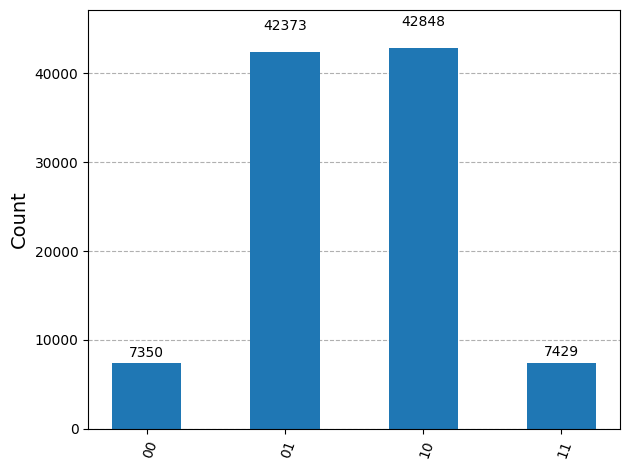

In [14]:
from qiskit_aer.primitives import SamplerV2 as sampler

h = 1; k = 1;
theta = -np.arcsin((1/np.sqrt(2))*(np.sqrt(1+h/np.sqrt(h**2+k**2))))

# Circuit V

qcV = QuantumCircuit(2)

# Prepare the ground state
qcV.ry(2*theta,0)
qcV.cx(0,1)

# Measure Energies
qcV.h(0)
qcV.h(1)
qcV.measure_all()

# Circuit H

qcH = QuantumCircuit(2)

# Prepare the ground state
qcH.ry(2*theta,0)
qcH.cx(0,1)

# Measure Energies
qcH.measure_all()

###################################################################################################################################################################################################

# Initiate simulator
simulator = AerSimulator()

# Parameters
n_shots = 100000

# Generate circuits
qcH = transpile(qcH, simulator, optimization_level=3)

qcV = transpile(qcV, simulator, optimization_level=3)

# Run job with Sampler
jobA = sampler().run([qcH], shots=n_shots)
jobB = sampler().run([qcV], shots=n_shots)

###################################################################################################################################################################################################
result = jobA.result()[0]
counts = result.data.meas.get_counts()

# Energies
ene_A = (h**2)/(np.sqrt(h**2+k**2))
ene_B = (h**2)/(np.sqrt(h**2+k**2))

# Error arrays
error_A = []
error_B = []

# Calculate errors
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_A += h*(-1)**int(bit_string[0])*count/n_shots
        ene_B += h*(-1)**int(bit_string[1])*count/n_shots

        for i in range(count):
            error_A.append(h*(-1)**int(bit_string[0]))
            error_B.append(h*(-1)**int(bit_string[1]))

# Print results
print("H_A =",ene_A,"±",np.std(error_A)/np.sqrt(n_shots))
print("H_B =",ene_B,"±",np.std(error_B)/np.sqrt(n_shots))


result = jobB.result()[0]
counts = result.data.meas.get_counts()

# Energies
ene_V = (2*k**2)/(np.sqrt(h**2+k**2))

# Erros arrays
error_V = []

# Calculate energies and errors
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_V += 2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[1])*count/n_shots

        for i in range(count):
            error_V.append(2*k*(-1)**(int(bit_string[1])))

# Print results
print("V =",ene_V,"±",np.std(error_V)/np.sqrt(n_shots))

###################################################################################################################################################################################################
print("E_A =", ene_A + ene_V)
print("E_B =", ene_B + ene_V)

plot_histogram(counts)